# Контекст
***
___Аналитик крупного интернет-магазина вместе с отделом маркетинга готовит список гипотез для увеличения выручки.<br> Приоритизация гипотез, запуск A/B-теста и анализ его результатов.___<br><br>
***
__Этапы работы:__ 
>  - _приоритизация гипотез,_ 
>  - _запук A/B-теста,_ 
>  - _анализ его результатов._


# Описание данных

__Данные для первой части: "Приоритезация гипотез"__

- _Hypothesis_ — краткое описание гипотезы;
- _Reach_ — охват пользователей по 10-балльной шкале;
- _Impact_ — влияние на пользователей по 10-балльной шкале;
- _Confidence_ — уверенность в гипотезе по 10-балльной шкале;
- _Efforts_ — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

__Загрузка библиотек__

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime, timedelta

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import math
from math import sqrt
from math import factorial

import scipy
from scipy import stats as st
from scipy.stats import binom, norm 

__Вспомогательные списки__

In [2]:
colors = ['indigo', 'olive', 'orange', 'turquoise', 'coral', 'teal', 'crimson', 'silver', 'gold', 'brown', 'grey',
 '#D2691E',#'purple'
 'black', 'r', 'g', 'b', 'c', 'm', 'y', 'lime', 'pink', 'blueviolet', 'mediumpurple', 'slateblue', 'plum', 'orchid', 'deeppink', 
 'cyan', 'steelblue', 'darkcyan', 'lightseagreen', 'purple', 'mediumvioletred'
 ]

line_style = [(5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1)), (0, (3, 10, 1, 10))\
,  (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (1, 10)), (0, (1, 1)), (0, (1, 1))]

markers = ['|' ,"p" , "X", "*", 'o', "1", "<", ".", ","] 

__Вспомогательные функции__

In [3]:
# Функция прорисовки фонового градиента

def grad(top, mid, bot):

    # Размер матрицы градиента
    size = 1024

    plt.figure(figsize=(11, 8)).patch.set_facecolor('#f6f5f7') # Цвет рамки
    plt.rcParams['axes.facecolor'] = '#e0e0e0' # Цвет фона


    # Линейный градиент
    gradient1 = np.linspace(0, 1, size).reshape(128, 8)
    gradient1 = np.repeat(gradient1, size, axis=0)

    # Логарифмический градиент
    gradient2 = np.logspace(1, 0, size).reshape(128, 8)
    gradient2 = np.repeat(gradient2, size, axis=0)

    plt.imshow(gradient1, aspect='auto', cmap='Blues', origin='lower', extent=[0, 30, mid, top], alpha=0.3) #"горизонт"
    plt.imshow(gradient2, aspect='auto', cmap='Reds', origin='lower', extent=[0, 30, bot, mid], alpha=0.3)  

    # Устанавливаем цвет рамки
    for side in ['bottom', 'top', 'right', 'left']:
        plt.gca().spines[side].set_color('#e0e0e0')


In [4]:
# Функция добавления подписей графикам

def leg(title, xlab, ylab, legend, n):

    plt.grid(True, color='#f6f5f7', linewidth=1.3)   

    plt.legend(legend, labelcolor=colors[n:20], 
                 facecolor='#ffe4c4', fontsize=12
              )    

    plt.title(title,  
              pad=25, fontsize=15, color='#133333',
              bbox={'facecolor': '#e0e0e0', 'edgecolor': '#a5886d', 'alpha': 0.5, 'pad': 5}
             )


    plt.xlabel(xlab, fontsize=15, color='#333333')
    plt.xticks(rotation=50)#ticks=list(range(1980, 2015, 5)))

    plt.ylabel(ylab, va='bottom', rotation=90, ha='center', labelpad=10, fontsize=15, color='#333333')

    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[n:20])
    
    plt.show()

In [5]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[5:20])

In [6]:
pd.set_option('display.max_colwidth', None) # Для отображения названий колонок целиком
#pd.reset_option('display.max_colwidth') # Откат этой настройки

## Часть. Приоритизация гипотез.

__В файле `/datasets/hypothesis.csv` хранятся 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами _Reach, Impact, Confidence и Effort_.__


__Задача:__
***

- __`Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.`__<br>   
***
- __`Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.`__<br>
***
- __`Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.`__
***

### Загрузка данныx первой части проекта и подготовка их к анализу

 >  `Загрузим данные о гипотезах в таблицу, изучим и подготовим к дальнейшему анализу при необходимости`

#### Загрузка файла в датафрейм

In [7]:
try:
    hypo = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypo = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

#### Изучение датафрейма с гипотезами

`Так как в таблице информация всего о 9 гипотезах, выведем её целиком:`

In [8]:
hypo.head(10).style.set_caption('Таблица с гипотезами')

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [9]:
hypo.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


 _ᅠ ᅠ С типами данных и с самими данными всё в порядке. Приведём названия колонок к змеиному стилю:_

In [10]:
hypo.columns = hypo.columns.str.lower()

***
__Вывод по предобработке данных первой части:__<br>
<br>
ᅠ _`Данные загружены в датафрейм и проверены на отсутствие аномалий и соответствие типов данных. Они представляют собой ранжирование 9-ти гипотез по пяти признакам:`_    
- _`Hypothesis — краткое описание гипотезы;`_
- _`Reach — охват пользователей по 10-балльной шкале;`_
- _`Impact — влияние на пользователей по 10-балльной шкале;`_
- _`Confidence — уверенность в гипотезе по 10-балльной шкале;`_
- _`Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.`_<br> <br> 
  
ᅠ __`Общая характеристика данных:`__<br>  
ᅠ _`Типы и качество данных во всех исходных таблицах приемлемое. Названия колонок приведены к змеиному стилю. Можем переходить к приоритезации гипотез.`_
***

### Приоритизация гипотез методами ICE & RICE и сравнение полученных результатов. 

 >  `Последовательно применим методы ICE и RICE для приоритизации гипотез и сравним полученные в результате чарты.`

#### Применение фреймворка ICE для приоритизации гипотез. Сортировка по убыванию приоритета.

`Фреймворк ICE состоит из трёх компонент:`
- _Impact_ — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- _Confidence_ — насколько мы уверены, что это изменение повлияет на пользователей именно так; 
- _Efforts_ — сколько стоит протестировать эту гипотезу.

`Каждый компонент в нашем случае оценён по 10-бальной системе. Ниже формула рассчёта рейтинга приоритетности гипотез с применением фреймворка ICE:`

In [11]:
hypo['ICE'] = hypo['impact'] * hypo['confidence'] / hypo['efforts']
    
hypo[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).style.format({'ICE': '{:.2f}'}).set_caption(
      'Рейтинг лучших гипотез, фреймворк ICE')

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


ᅠ _В результате произведённых с помощью фреймворка ICE рассчётов гипотезы расположились в следующем порядке от большего рейтинга к меньшему:_    
1. _`На первое место по методике ICE вышла`__`скидка на день рождения`__`(16.2). У неё практически максимальные показатели по влиянию на пользователей и уверенности в гипотезе, и средние усилия на её проверку. Но охват имеет минимальный рейтинг - это не сможет не сказаться на итоговой оценке по методике RICE;`_
2. _`На втором месте, с небольшим отставанием по причине чуть больших усилий на проверку(13.33),`__`добавление двух новых каналов привлечения трафика`__`. Охват этой гипотезу повыше, но тоже небольшой - её позиции могут пошатнуться при переходе к RICE;`_
3. _`На третьем`__`добавление формы подписки на все основные страницы`__`(11.2) - ниже влияние и уверенность, средние усилия, но максимальный охват - у этой гипотезы RICE'кое будущее:);`_
4. _`Четвёртое -`__`показать на главной странице баннеры с актуальными акциями и распродажами`__`. Небольшие усилия по проверке, хорошая уверенность, но очень слабое влияние на пользователей. Сейчас они, конечно, везде. Охват средний;`_
5. _`И на пятом с последним более-менее значимым рейтингом - `__`гипотеза о добавлении блоков рекомендаций товаров на сайт интернет магазина`__`. Похожа по сути и по показателям на предыдущую, но с очень хорошим охватом. При применении RICE может удивить.`_

#### Применение фреймворка RICE для приоритизации гипотез. Сортировка по убыванию приоритета.

ᅠ `Фреймворк RICE состоит из четырёх компонент:`
- _Reach_ — скольких пользователей затронет изменение, которое вы хотите внести;
- _Impact_ — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- _Confidence_ — насколько мы уверены, что это изменение повлияет на пользователей именно так; 
- _Efforts_ — сколько стоит протестировать эту гипотезу.

ᅠ `Каждый компонент в нашем случае оценён по 10-бальной системе. Ниже формула рассчёта рейтинга приоритетности гипотез с применением фреймворка RICE и рейтинг, полученный с его помощью. Для сравнения слева приведены очки рейтинга по системе ICE:`

In [12]:
hypo['RICE'] = hypo['impact'] * hypo['confidence'] * hypo['reach']/ hypo['efforts']
    
display(
    hypo[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False).
    style.format({'ICE': '{:.2f}', 'RICE': '{:.2f}'}).set_caption(
          'Рейтинг лучших гипотез, фреймворк RICE (ICE для сравнения - слева)'))

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


 _ᅠ ᅠ Также рассмотрим таблицу с теми же данными, но отсортированными по рейтингу ICE. Слева тоже рейтинг RICE для сравнения:_

In [13]:
display(hypo[['hypothesis', 'RICE', 'ICE']].sort_values(by='ICE', ascending=False).style.format(
             {'RICE': '{:.2f}', 'ICE': '{:.2f}'}).set_caption(
              'Рейтинг лучших гипотез, фреймворк ICE (RICE для сравнения - слева)'))

,hypothesis,RICE,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00,1.00


#### Сравнение результатов приоритизации гипотез при применении RICE вместо ICE. 

ᅠ _Показатель охвата Reach, являясь множителем прямой пропорциональности, естественно внёс серьёзные коррективы в рейтинг ICE. В результате произведённых с помощью фреймворка RICE рассчётов гипотезы расположились в следующем порядке от большего рейтинга к меньшему:_    
1. _`На первое место по методике RICE`__`добавление формы подписки на все основные страницы`__`. Пришла с 3-го места. Как и предполагалось выше, максимальный охват сыграл решающую роль и он тривиально объясним.                                            вышла скидка на день рождения (16.2). У неё практически максимальные показатели по влиянию на пользователей и уверенности в гипотезе, и средние усилия на её проверку. Но охват имеет минимальный рейтинг - это не сможет не сказаться на итоговой оценке по методике RICE;`_
2. _`На втором месте(5-е по ICE)`__`добавление блоков рекомендаций товаров на сайт интернет магазина`__`. Причина такого взлёта - опять же высокий охват. Хорошая гипотеза, с высокой уверенностью и низкими затратами на проверку;`_
3. 1. _` `__`Добавление двух новых каналов привлечения трафика`__`спустилось на третье из-за Reach=3. Возможно, два канала - не столь много по отношению к имеющимся каналам привлечения;`_
   2. _` Также на третьем -`__`показать на главной странице баннеры с актуальными акциями и распродажами`__`. Эта гипотеза осталась на прежних позициях из-за среднего охвата;`_
4. _`И на последнее в этом списке спустилась`__`скидка на день рождения`__`. Настолько значимым является показатель охвата при применении RICE`_

***
__Промежуточный вывод:__<br>
***

 ᅠ ___`Обзор данных`___    
 - _`Данные загружены и проверены на соответствие типов и отсутствие аномалий.`_<br>
 - _`Качество данных во всех исходных таблицах приемлемое.`_<br>
 - _`Названия колонок приведены к "змеиному стилю".`_
***
ᅠ ___`Приоритизация гипотез`___ 

_Методика ICE_

1. Скидка на день рождения (16.2) - занимает первое место по методике ICE с высоким влиянием (Impact), уверенностью (Confidence) и средними затратами (Efforts).
2. Добавление двух новых каналов привлечения трафика (13.33) - на втором месте с чуть большими затратами на проверку, чем у первой гипотезы.
3. Добавление формы подписки на все основные страницы (11.2) - на третьем месте с низким влиянием и уверенностью.
4. Показать на главной странице баннеры с актуальными акциями и распродажами - на четвертом месте с низким влиянием, но с хорошей уверенностью и низкими затратами.
5. Добавление блоков рекомендаций товаров на сайт интернет-магазина - на пятом месте с похожими показателями на предыдущую гипотезу.

_Методика RICE_

1. Добавление формы подписки на все основные страницы - занимает первое место по RICE с высоким охватом (Reach), перейдя с третьего места по ICE.
2. Добавление блоков рекомендаций товаров на сайт интернет-магазина - на втором месте, перейдя с пятого места по ICE, благодаря высокому охвату.
3. Добавление двух новых каналов привлечения трафика - спустилось на третье место из-за невысокого охвата.
4. Показать на главной странице баннеры с актуальными акциями и распродажами - осталось на прежнем месте. Охват средний.
5. Скидка на день рождения - спустилась на последнее место из-за минимального охвата.
    
>___`Вывод:`___  
> - _`Приоритизация по RICE и ICE дает схожие результаты, однако опыт (Reach) играет ключевую роль в RICE, позволяя гипотезам с высоким охватом занять более высокие позиции.`_
> - _`Важно отметить, что результаты приоритизации не окончательны и могут меняться в зависимости от конкретных условий и целей тестирования.`_ 
> - _`Следующим шагом будет анализ результатов A/B-теста для подтверждения или опровержения гипотез.`_
 
***  
ᅠ ᅠ ᅠ ___`Рекомендации`___
    
 - _`Рекомендуется провести дополнительный анализ гипотез, учитывая специфику бизнеса и цели тестирования.`_<br>
 <br>
 - _`Важно убедиться, что выбранные метрики для оценки гипотез отражают ключевые показатели успеха проекта.`_ <br>
 <br>
 - _`Стоило бы попробовать уточнить конкретные действия по "Добавлению формы подписки", как то:`_

    1. _Определить, на каких страницах будет располагаться форма подписки: На главной странице, на страницах категорий, на страницах товаров?_
    2. _Провести A/B-тест с разными вариантами формы подписки: Например, с разным текстом, с разными стимулами к подписке (скидка, подарок, доступ к эксклюзивным предложениям)._    
ᅠ ᅠ     
 - _`Сфокусироваться на "Добавлении блоков рекомендаций товаров":`_

     1. _Использовать разные алгоритмы рекомендаций: Например, рекомендации по похожим товарам, рекомендации на основе истории покупок, рекомендации на основе просмотренных товаров и т.д._
     2. _Тестировать разные виды рекомендаций: Например, рекомендации в виде списка, рекомендации в виде карусели, рекомендации в виде баннера._
     3. _Отслеживать показатели эффективности рекомендаций: Количество просмотров рекомендованных товаров, конверсия в покупки рекомендованных товаров, доход с рекомендованных товаров._<br>
ᅠ ᅠ 
 - _`Возможно изучить, какие акции и распродажи реально влияют на покупательское поведение: Не все акции одинаково эффективны. Проанализируйте данные о прошлых акциях, чтобы узнать, какие из них принесли самый большой доход.`_
 <br>
 - _`Оценить спрос на товары, которые рекомендуются: Есть ли действительно интерес к рекомендованным товарам или они неактуальны? Проанализировать данные о покупках и просмотрах товаров.`_
 <br>
 - _`Проанализировать существующие каналы привлечения трафика: С каких каналов приходят наиболее ценные клиенты? Какие каналы наиболее эффективны с точки зрения стоимости привлечения клиента (CAC)?`_
 ***

## Часть.  Анализ A/B-теста

Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

__Задача__

- Проанализируйте A/B-тест:
- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### Загрузка данныx второй части проекта и подготовка их к анализу

 >  `Загрузим данные о заказах и пользователях в таблицы, изучим и подготовим к дальнейшему анализу`

#### Загрузка файлов в датафреймы

In [14]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

#### Изучение датафрейма с заказами

`Просмотрим информацию и статистики таблицы с заказами и заодно проверим её на наличие дубликатов и пропусков.`

In [15]:
orders.head(7).style.set_caption('Таблица с заказами')

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B


 _ᅠ ᅠ Cразу приведём названия колонок к змеиному стилю:_

In [16]:
orders.columns = [x.replace('Id', '_id') for x in orders.columns]

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


 _ᅠ ᅠ Пропусков в данных нет._

In [18]:
print('Количество дубликатов:', orders.duplicated().sum())

Количество дубликатов: 0


 _ᅠ ᅠ Дубликатов тоже нет. Посмотрим на статистики:_

In [19]:
orders.describe().round(1).style.format({'revenue': '{:.0f}',
                                         'transaction_id': '{:.0f}', 'visitor_id': '{:.0f}'}
                                        ).set_caption('Статистики таблицы с заказами') 

,transaction_id,visitor_id,revenue
count,1197,1197,1197
mean,2155621386,2165960143,8348
std,1229084905,1236014192,39191
min,1062393,5114589,50
25%,1166775572,1111826046,1220
50%,2145193898,2217984702,2978
75%,3237740112,3177606451,8290
max,4293855558,4283872382,1294500


In [20]:
print('Самый ранний заказ:', orders['date'].min())
print('Самый поздний заказ:', orders['date'].max())

Самый ранний заказ: 2019-08-01
Самый поздний заказ: 2019-08-31


 _ᅠ ᅠ Каких-то очевидных аномалий, как то отрицательных значений, не наблюдается. Даты находятся в пределах июля 2019г, выручка от одного заказа колеблется от 50 до 1.3 млн. Пропусков и дубликатов нет. Все типы данных удовлетворяют нашим задачам.<br> 
ᅠ ᅠ Визуализируем распределение выручки, чтобы определить степень влияния дорогих заказов на статистики._

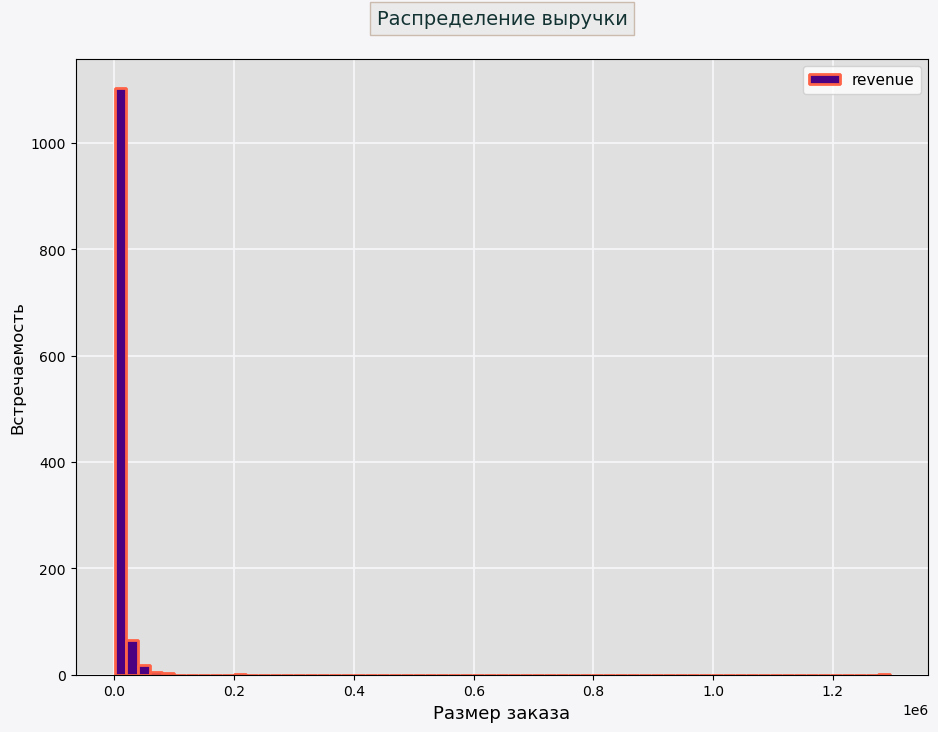

In [21]:
plt.figure(figsize=(11, 8)).patch.set_facecolor('#f6f5f7') # Цвет рамки
plt.rcParams['axes.facecolor'] = '#e0e0e0' # Цвет фона

orders['revenue'].hist(bins=65,
           edgecolor='tomato', color='indigo',
           hatch="", linewidth=-2)


plt.gca().set_axisbelow(True)

plt.grid(True, color='#f6f5f7', linewidth=1.3) 

plt.title('Распределение выручки', fontsize = 14,
          pad=25, color='#133333',
          bbox={'facecolor': '#e0e0e0', 'edgecolor': '#a5886d', 'alpha': 0.5, 'pad': 5})


plt.legend(([orders.columns[3]]), facecolor='w', fontsize = 11)

plt.xlabel('Размер заказа', fontsize = 13)
plt.ylabel('Встречаемость', fontsize = 12)
pass

 _ᅠ ᅠ Цены распределены очень неравномерно, с малым количеством очень весомых заказов, которые, естественно, сильно влияют на собираемые статистики, даже единичные из них. В будующем надо будет это учесть.<br> 
ᅠ ᅠ Посмотрим на количество покупателей и покупок в каждой группе:_

In [22]:

print('Кол-во покупателей в группе А:', len(orders[orders['group'] == 'A'].groupby('visitor_id'))),
print('Кол-во покупателей в группе B:', len(orders[orders['group'] == 'B'].groupby('visitor_id')))
None

Кол-во покупателей в группе А: 503
Кол-во покупателей в группе B: 586


In [23]:
print('Кол-во покупок в группе А:', len(orders[orders['group'] == 'A']))
print('Кол-во покупок в группе B:', len(orders[orders['group'] == 'B']))
None

Кол-во покупок в группе А: 557
Кол-во покупок в группе B: 640


 _ᅠ ᅠ Видна приличная разница(около 15%) между группами как по количеству покупателей, так и по количеству покупок. Не обязательно она вызвана результатами применения теста. Возможно, стоит перепроверить А/А-тестом качество разделения покупателей по группам. Проверим, не пересекаются ли группы покупателей._

In [24]:
shared_orderers = orders.query('group == "A"')[orders[orders['group'] == 'A'][
             'visitor_id'].isin(orders[orders['group'] == 'B'][
             'visitor_id'])]['visitor_id']
print('Покупателей в обеих группах:', shared_orderers.nunique())

Покупателей в обеих группах: 58


 _ᅠ ᅠ У нас 58 покупателей, входящих в обе группы, что примерно 10% от размера каждой из групп покупателей. Можно было бы попробовать удалить их из анализа, что может с одной стороны улучшить разделение показателей, исключив покупателей, на которых действуют условия как первой, так и второй группы, но с другой стороны это изменит баланс "посетители\покупатели", и мы не сможем удалить данные этих пользователей из таблицы с посетителями, что вмешается в рассчёты. Просто будем иметь ввиду, что разделение на группы несовершенно._

***
__Промежуточный вывод:__<br>
<br>
ᅠ _`Информация о заказах загружена в датафрейм и проверена на отсутствие аномалий и соответствие типов данных. Она представляет собой данные за июль 2019, представленные в 5 колонках:`_    
- _`transaction_id — идентификатор заказа;`_
- _`visitor_id — идентификатор пользователя, совершившего заказ;`_
- _`date — дата, когда был совершён заказ;`_
- _`revenue — выручка заказа;`_
- _`group — группа A/B-теста, в которую попал заказ.`_<br><br>
  
ᅠ __`Общая характеристика данных:`__<br><br>
ᅠ _`Типы и качество исходных данных приемлемое. Разделение на группы местами вызывает вопросы, но в целом устраивает. На то, что есть около 10% покупателей, относящихся к обеим группам, как мне кажется, стоило бы обратить внимание. Также данные выглядят довольно чувствительно к выбросам - большим заказам.`_<br> 
ᅠ _`Названия колонок приведены к змеиному стилю.`_
***

#### Изучение датафрейма с записями о количестве ежедневных посетителей 

`Просмотрим информацию и статистики таблицы с количеством посетителей в определённую дату и заодно проверим её на наличие дубликатов и пропусков.`

In [25]:
visitors.head().style.set_caption('Количество пользователей в указанную дату')

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [26]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [27]:
print('Количество дубликатов:', visitors.duplicated().sum())

Количество дубликатов: 0


 _ᅠ ᅠ Пропусков в данных нет.  Дубликатов тоже нет. Посмотрим на статистики:_

In [28]:
visitors.describe().round(1).style.format({'visitors': '{:.0f}'}).set_caption('Статистики количества пользователей в указанную дату') 

,visitors
count,62
mean,607
std,114
min,361
25%,534
50%,624
75%,710
max,770


In [29]:
visitors['group'].value_counts() # Количество строк в каждой группе

group
A    31
B    31
Name: count, dtype: int64

In [30]:
# pd.to_datetime(visitors['date']).describe() # Выдаёт предупреждение
visitors['date'].min(), visitors['date'].max()


('2019-08-01', '2019-08-31')

_ᅠ ᅠДаты в каждой группе соответствуют по количеству и крайним значениям дням июля. Каких-то очевидных аномалий не наблюдается. Количество посетителей в день колеблется от 360 до 770 с медианой в 620. Проверим равномерность разделения по группам массы посетителей_ 

In [31]:
print('Кол-во посетителей в группе А за месяц:', visitors[visitors['group']=='A']['visitors'].sum())
print('Кол-во посетителей в группе B за месяц:', visitors[visitors['group']=='B']['visitors'].sum())

Кол-во посетителей в группе А за месяц: 18736
Кол-во посетителей в группе B за месяц: 18916


_ᅠ ᅠКоличество посетителей в каждой группе практически не отличается, что хорошо._

***
__Промежуточный вывод:__<br>
<br>
ᅠ _`Информация о количестве посетителей в определённую дату загружена в датафрейм и проверена на отсутствие аномалий и соответствие типов данных. Она представляет собой данные за июль 2019, представленные в 5 колонках:`_    
- _`date — дата;`_
- _`group — группа A/B-теста;`_
- _`visitors — количество пользователей в указанную дату в указанной группе A/B-теста`_<br> <br> 

ᅠ __`Общая характеристика данных:`__<br>  
ᅠ _`Типы и качество исходных данных приемлемое. Нет ни пропусков, ни дубликатов. Каждой группе теста соответствует 31 строка с данными - по числу дней в июле.Суммарное количество ежедневных посетителей в каждой группе практически равно, что является прихнаком хорошего деления на группы теста. Разброс количества посетителей - от 350 до 770. Характер разброса во времени(цикличность, рост/падение или иная динамика) не изучались`_
***

__Вывод по предобработке данных второй части:__<br>
<br>
ᅠ ᅠ  _` В нашем распоряжении имеются данные в виде двух таблиц:`<br>     
`-`  `"orders"` `: c информацией о заказах (идентификатор заказа, идентификатор заказчика, дата совершения заказа, выручка с заказа, группа A/B-теста.);`  
`-`  `"visitors"` `: с информацией о количестве посетителей сайта в определенный день, разделенной на группы теста (день в границах июля 2019, группа теста, количество посетителей сайта в этот день).`<br>  
ᅠ ᅠ `Пропусков и дубликатов в таблицах не обнаруженно, нулевых и аномальных нет. Названия столбцов были преобразованы к "змениному" стилю.`  
ᅠ ᅠ `Разделение на группы выглядит удовлетворительным, за исключением пересекающихся заказов. Дисперсионность выручки от заказа очень велика - много дешевых заказов и единичные очень дорогие, что делает статистики уязвимыми к выбросам. Учитывая это, можем переходить непосредственно к A/B-тесту.`_
***

# A/B-тест

***
 - __`Для начала посчитаем значимые кумулятивные метрики, визуализируем и проанализируем их`__ 
 ***
 - __`Исходя из результатов проведённого анализа будем адаптировать нашу стратегию по отношению к выбивающимся значениям`__
 ***
 - __`Решив, какие значения считать выбивающимися, удалим записи с ними и найдём те же метрики, но на чистых данных`__
 ***
 - __`Найдём различия в результатах статистического анализа "сырых" и "очищенных" данных. Сделаем вывод из найденных различий и в целом по вопросу о продолжении или остановке теста на данном этапе`__
***

###  Анализ кумулятивных метрик грязных данных A/B-теста.

 >  ᅠ ᅠ`Так как по центральной предельной теореме кумулятивные метрики должны в итоге сходиться к асимптоте, то с их помощью удобно определять момент достаточного накопления статистических данных для принятия решения об окончании проведения теста, т.е. решается проблема подсматривания - остановка теста при достижении определённой метрикой порогового значения, например, статистической значимости различия, что может быть обусловлено выбросом или иной случайной флуктуацией`<br>
ᅠ ᅠ`Также на графиках кумулятивных статистик видно влияние выбросов, резко меняющее динамику поведения графиков, что помогает в определении границы выбросов. Относительные куммулятивные метрики тоже очень показательны.`

`Для построения графиков на основе накопительных данных необходимо собрать агрегированный датафрейм, включающий информацию о дате, группе теста, накопительном количестве заказов, пользователей, среднем чеке и кумулятивном количестве посетителей магазина:` 

1. Сформируем массив уникальных пар значений дат и групп теста.

2. Создадим датафрейм cumulativeData с колонками: дата, группа (A или B), количество заказов, пользователей, выручка, количество посетителей.

3. Соберем агрегированные кумулятивные данные о заказах, учитывая условия по датам и группам.

4. Аналогичным образом получим агрегированные данные о посетителях магазина по дням.

5. Объединим обе таблицы в одну, чтобы получить итоговый датафрейм с понятными названиями столбцов для анализа.

`Построим графики кумулятивной выручки по дням и группам A/B-тестирования.`

#### Построение графика кумулятивной выручки по группам.

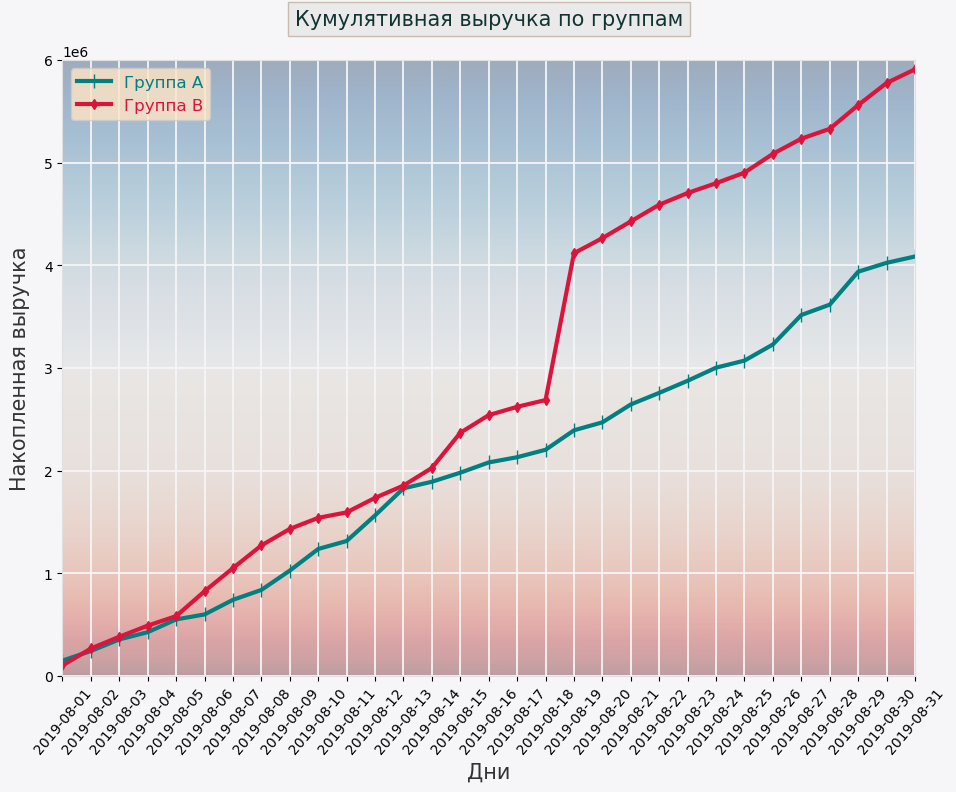

In [32]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]



grad(6000000, 3000000, 0)


plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A',
        marker='|', markersize=10, linewidth=3
        )
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B',
        marker='d', markersize=5, linewidth=3
        )


leg('Кумулятивная выручка по группам', 'Дни', 'Накопленная выручка', ['Группа А', 'Группа B'], 5)


 _ᅠ ᅠ Выручка обеих групп почти равномерно увеличивается в течение всего теста. Хороший знак, но эта метрика всегда растёт и рассматривается как метрика тщеславия. Нужен более высокий порядок характера поведения этой метрики или её относительное изменение.<br>
ᅠ ᅠ В группе B наблюдается резкий скачок после 17-го августа, вероятно, из-за всплеска числа заказов или появления дорогостоящих заказов. Необходимо провести дополнительный анализ этих выбросов, т.к. они радикально меняют соотношение накопленной выручки между группами._
***

#### Построение графика кумулятивного среднего чека по группам.

`Построим графики изменения среднего чека по группам, разделив кумулятивную выручку на кумулятивное число заказов:`

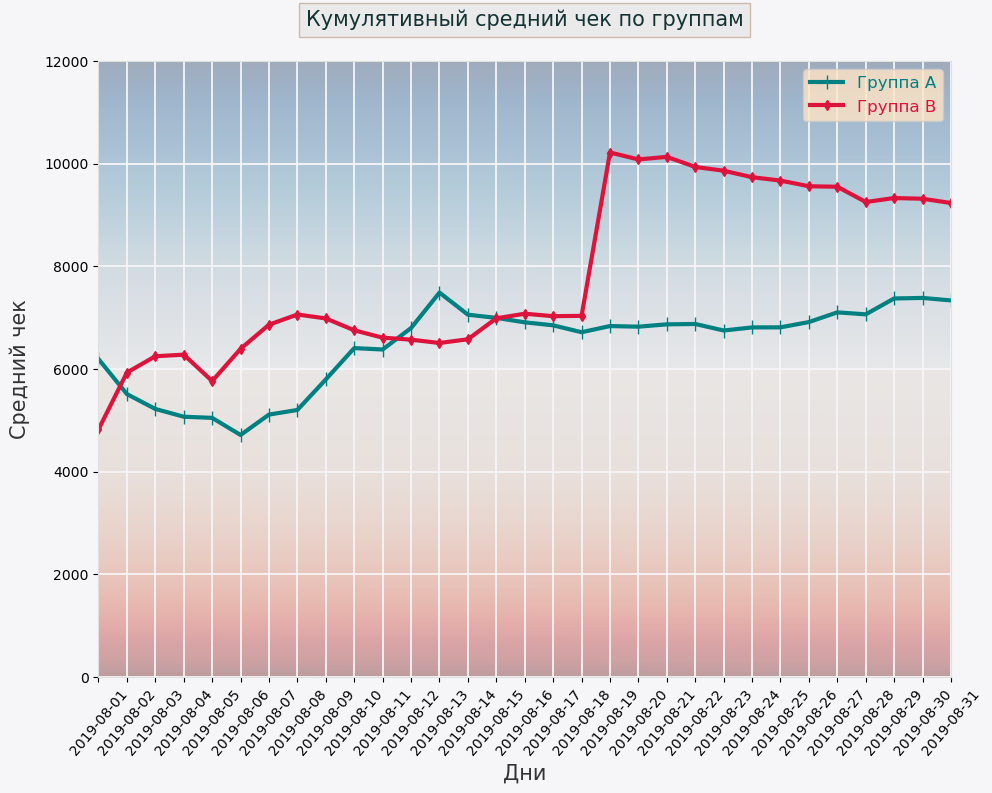

In [33]:
grad(12000, 6000, 0)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'],
        marker='|', markersize=10, linewidth=3
        )
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'],
        marker='d', markersize=5, linewidth=3
        )

leg('Кумулятивный средний чек по группам', 'Дни', 'Средний чек', ['Группа А', 'Группа B'], 5)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[11:20])


 _ᅠ ᅠ Средний чек группы A стабилизировался к концу теста, а в группе B наблюдается снижение после резкого скачка в середине месяца. Возможно, в группу B попали крупные заказы, что повлияло на средний чек. Для более точного анализа необходимо больше данных, чтобы определить реальный средний чек для группы B._
 ***

#### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.


`Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline():`

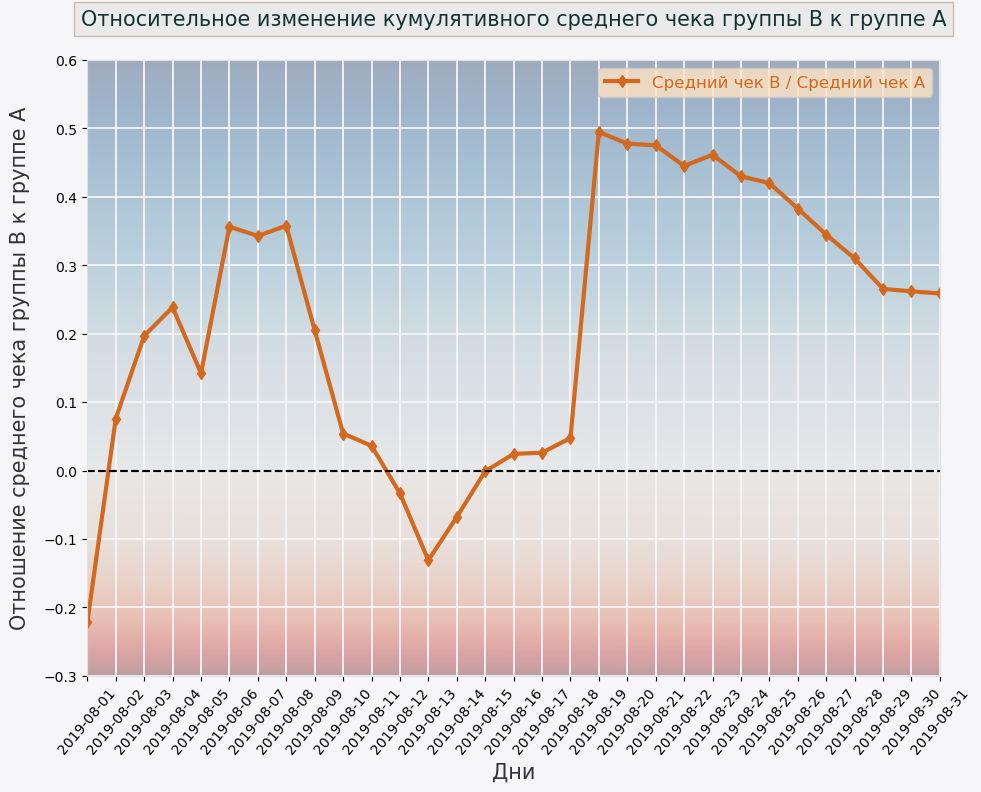

In [34]:
grad(0.6, 0, -0.3)


# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
         mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, marker='d', markersize=6, linewidth=3)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

leg('Относительное изменение кумулятивного среднего чека группы B к группе A',
     'Дни', 'Отношение среднего чека группы B к группе A', ['Средний чек B / Средний чек А'], 11)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[5:20])

 _ᅠ ᅠ График относительного изменения среднего чека группы B к группе A демонстрирует резкие скачки, что опять же говорит о наличии выбросов и крупных заказов в данных. Также флуктуации на первой трети графика могут быть объяснены высокой дисперсией в силу того, что ещё не накопилось достаточно данных и даже небольшое локальное преимущество может вылиться в большую относительную разницу. Необходимо провести дополнительный анализ, чтобы "увидеть" конкретные аномальные заказы и пользователей._
 ***

#### Построение графика кумулятивного среднего количества заказов на посетителя по группам.

`Аналогично проанализируем график кумулятивного среднего количества заказов на посетителя по группам:`

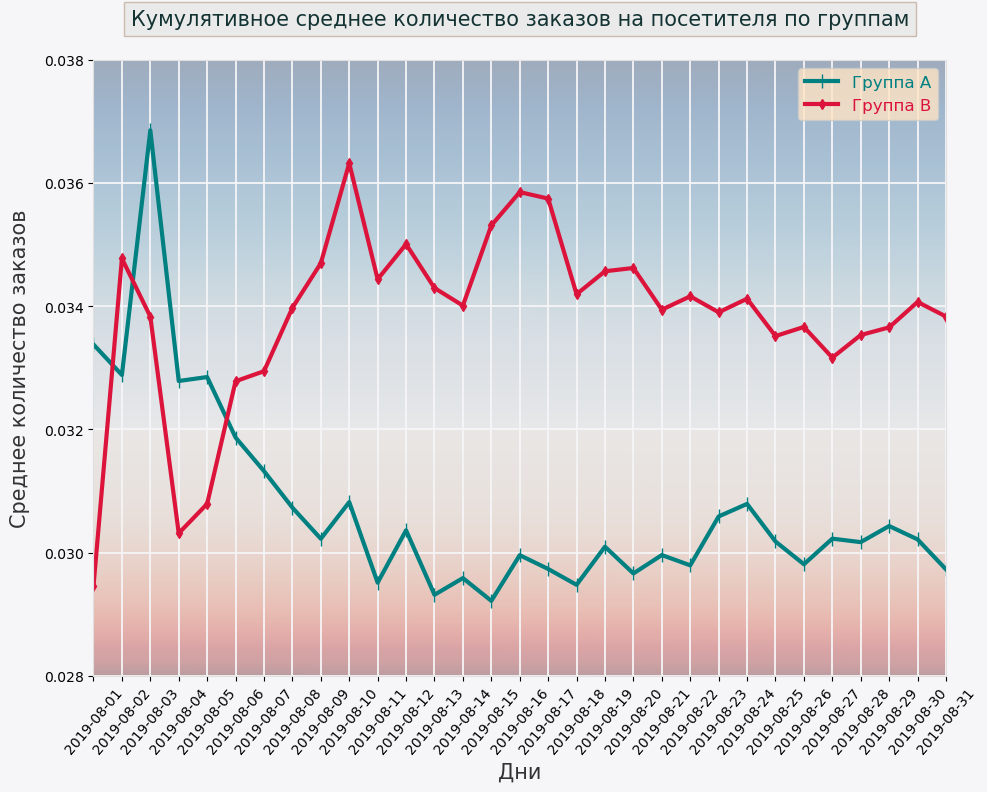

In [35]:
grad(0.038, 0.032, 0.028)


# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A',
         marker='|', markersize=10, linewidth=3)
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B',
         marker='d', markersize=5, linewidth=3)


leg('Кумулятивное среднее количество заказов на посетителя по группам',
     'Дни', 'Среднее количество заказов', ['Группа А', 'Группа B'], 5)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[11:20])

 _ᅠ ᅠ Кумулятивное среднее число заказов в группе B стабильно выше, чем в группе A, что говорит о более высоком уровне конверсии. Несмотря на начальные колебания, группа B демонстрирует более устойчивую позитивную динамику, чем группа A._
 ***

#### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.


`Построим график изменения отношения кумулятивного среднего количества заказов на посетителя группы B к группе A:`

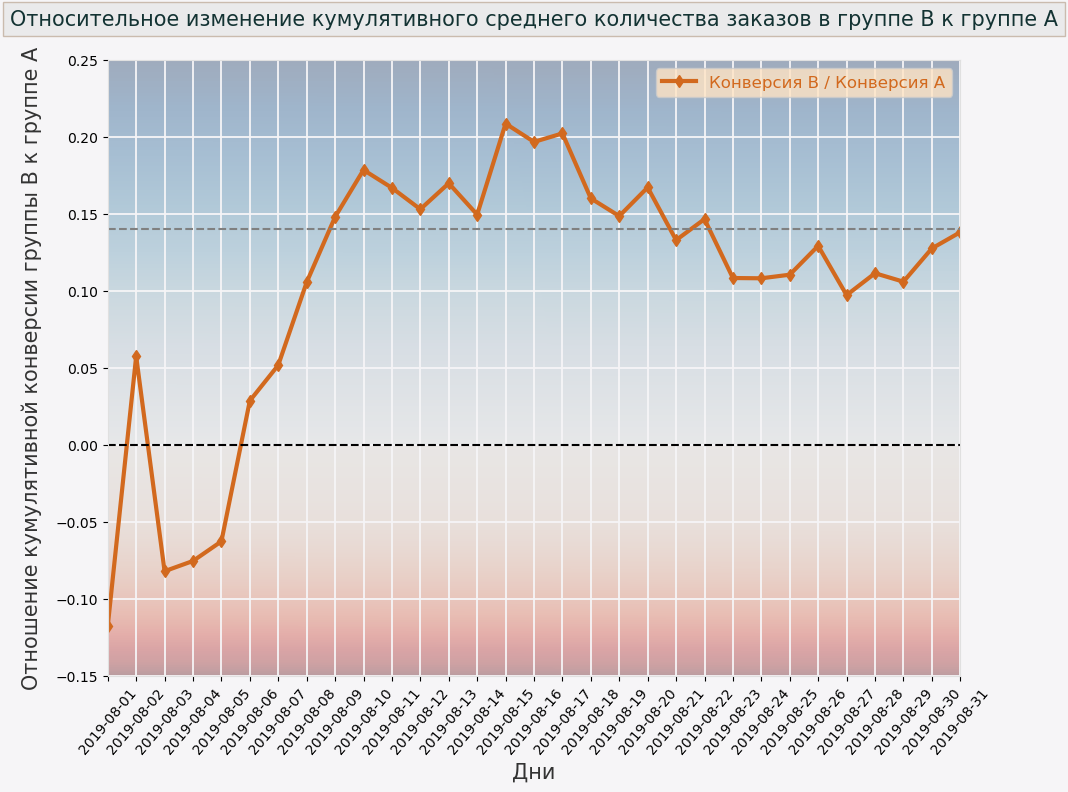

In [36]:
grad(0.25, 0, -0.15)


mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост кумулятивного среднего количества заказов ",
         marker='d', markersize=6, linewidth=3)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')


leg('Относительное изменение кумулятивного среднего количества заказов в группе B к группе A',
     'Дни', 'Отношение кумулятивной конверсии группы B к группе A', ['Конверсия B / Конверсия А'], 11)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[5:20])




 _ᅠ ᅠ В начале теста наблюдались существенные колебания отношения конверсии группы B относительно группы А. Это может быть связано с различными факторами, включая сезонность, случайные события и т.д. В целом, результаты теста показывают, что группа B демонстрирует более высокую конверсию. Несмотря на некоторые начальные колебания, конверсия группы B стабильно превосходит конверсию группы A на 10-15%, и к концу месяца даже демонстрирует тенденцию к росту. Назвать характер поведения графика установившимся сложно - он всё ещё подвержен заметным колебаниям._

***
__Промежуточный вывод:__<br>
<br>
ᅠ _`В целом, результаты теста показывают, что группа B демонстрирует значительно более высокую конверсию по сравнению с группой A. Несмотря на некоторые начальные колебания, конверсия группы B в последние две трети месяца стабильно превосходит конверсию группы A на 10-15%, и к концу месяца даже демонстрирует тенденцию к росту. Однако, стоит отметить несколько важных моментов:`_    
- _`Аномалии в данных: Наличие выбросов (например, крупных заказов) может искажать общую картину. Необходимо провести анализ данных после удаления аномалий, чтобы получить более точную оценку различия кумулятивных метрик между группами;`_
- _`Нестабильный средний чек: Средний чек в группе A стабилизировался к концу теста, но в группе B наблюдается небольшое снижение после резкого скачка - скорее всего крупный заказ или всплеск активности;`_
- _`Недостаточное количество данных: Тест проводился сравнительно небольшое количество времени, что затрудняет окончательные выводы. Возможно, группы также недостаточных размеров - такие вещи сложно моделируются и как правило выясняются эмпирически;`_
- _`Нестабильность конверсии: В начале теста наблюдались существенные колебания конверсии группы B. Это может быть связано с различными факторами, включая сезонность, случайные события и т.д.`_
  
ᅠ ᅠ __`Итог:`__  
ᅠ _`Для принятия решения о продолжении или остановке теста необходимо провести дополнительный анализ данных, исключив выбросы и оценив влияние других факторов и отсутствия выбросов. В следующем разделе мы проанализируем аномалии, чтобы получить более точную оценку эффективности групп.`_
***

### Анализ выбивающихся значений

 >  `В предыдущем разделе мы обнаружили, что в данных A/B-теста присутствуют аномалии, которые могут искажать результаты. Для более точной оценки эффективности тестируемых групп необходимо провести анализ выбивающихся значений.` 
>
 >  `В этом разделе мы будем рассматривать выбивающиеся значения по двум ключевым метрикам:`

__`Количество заказов:`__ ᅠНайдём клиентов, которые существенно отклоняются от среднего значения по количеству заказов. Они радикально влияют на показатель конверсии.<br> 
***
__`Размер выручки с заказа:`__ ᅠПроанализируем заказы, которые отличаются от среднего значения по сумме выручки. Эти заказы резко меняют показатель среднего чека.

>  `Для определения границы выбивающихся значений мы будем использовать 95-й и 99-й процентили. Это позволит нам выделить заказы, которые находятся в верхнем хвосте распределения и могут оказывать значительное влияние на общие результаты.` 
>
>  `Анализ выбивающихся значений поможет нам:`

- _Уточнить картину эффективности: Определить, насколько сильно аномалии влияют на результаты A/B-теста._<br>
- _Определить причины аномалий: Понять, какие факторы могут быть ответственны за выбивающиеся значения (например, ошибки в данных, нестандартные заказы, сезонные изменения и т.д.)._<br>
- _Принять обоснованное решение: Сформировать более точное представление о результатах теста и принять обоснованное решение о дальнейших действиях._
 


#### Анализ выбивающихся значений количества заказов

##### Построение точечного графика количества заказов по пользователям.

`Построим точечную диаграмму количества заказов на одного пользователя для визуализации выбросов:
`

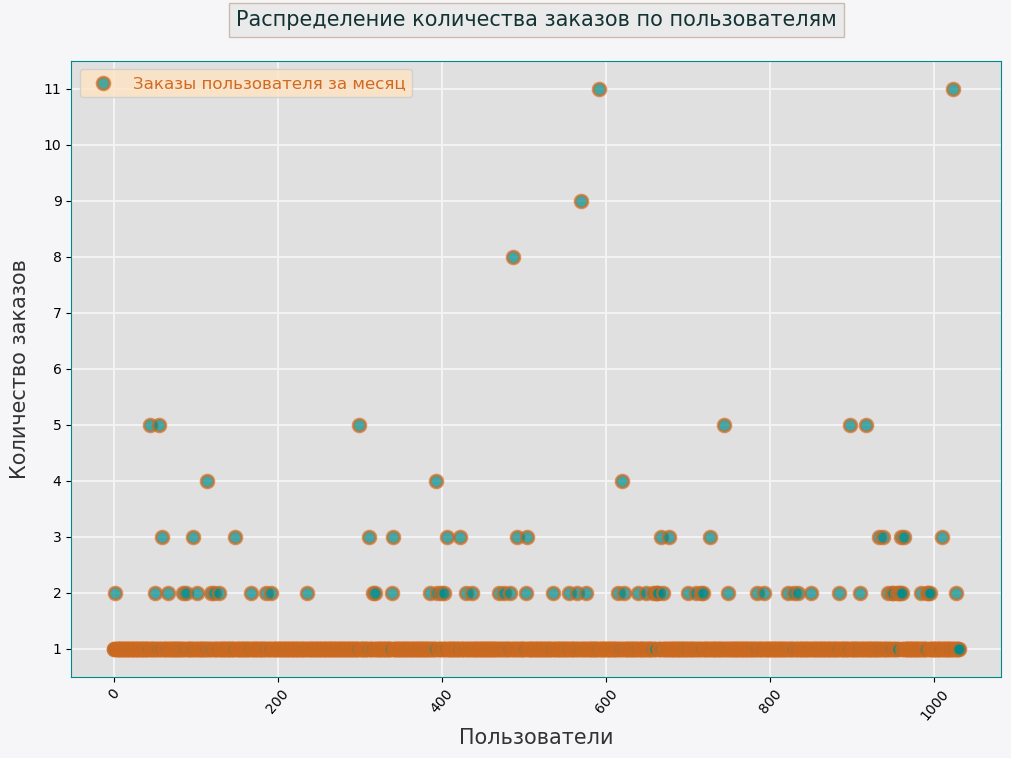

In [37]:
# Группируем по пользовательскому id и считаем количество уникальных транзакций на каждого
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']


# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
y_values = ordersByUsers['orders']


plt.figure(figsize=(12, 8)).patch.set_facecolor('#f6f5f7') # Цвет рамки

# Список сторон рамки
sides = ['bottom', 'top', 'right', 'left']

# Устанавливаем цвет рамки
for side in ['bottom', 'top', 'right', 'left']:
    plt.gca().spines[side].set_color('darkcyan')


plt.gca().set_axisbelow(True)

plt.scatter(x_values, y_values, alpha=0.7, color='darkcyan', edgecolor='#D2691E', s=85, linewidths=2)


plt.yticks(ticks=list(range(1, 12)))
leg('Распределение количества заказов по пользователям',
    'Пользователи', 'Количество заказов', ['Заказы пользователя за месяц'], 11)

 _ᅠ ᅠ Анализ распределения пользователей интернет-магазина по количеству покупок показывает, что большинство клиентов совершает 1-3 заказа за месяц, а более 3 заказов делают буквально единицы.  Вероятно, магазин торгует товарами не первой необходимости, такими как электроника, одежда или мебель, которые покупают не часто. Хорошо бы подробнее узнать, нет ли проблемы удержания пользователей, т.к. всё же есть отдельные случаи более 10 покупок за месяц.  
ᅠ ᅠ Для более точного понимания распределения и определения границы аномалий будет проведена дополнительная обработка данных, включая расчет 95-го и 99-го перцентилей количества заказов на пользователя._
***

##### Вычисление 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.


` Рассчитаем 95-й и 99-й перцентили количества заказов для определения границы аномальных пользователей:`

In [38]:
print('95 персентиль среднего чека:', np.percentile(ordersByUsers['orders'], 95))
print('99 персентиль среднего чека:', np.percentile(ordersByUsers['orders'], 99))

95 персентиль среднего чека: 2.0
99 персентиль среднего чека: 4.0


In [39]:
ordersByUsers.sort_values(by='orders', ascending=False).head(10).style.set_caption('Рейтинг пользователей по количеству покупок')

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


 _ᅠ ᅠ 5-% граница по самому большому количеству заказов - всего два заказа. Не выглядит рациональным считать всех пользователей с 2 заказами аномалиями. Четыре и больше заказов за месяц - у 1% покупателей. Считаю, что границу аномального количества покупок целесообразно установить в 4 заказа за месяц включительно. Это позволит исключить отдельные случаи, избыточно влияющие на общие метрики._
 ***

 #### Анализ выбивающихся значений стоимостей заказов

##### Построение точечного графика стоимостей заказов.

`Построим точечную диаграмму распределения стоимостей заказов для визуализации выбросов:
`

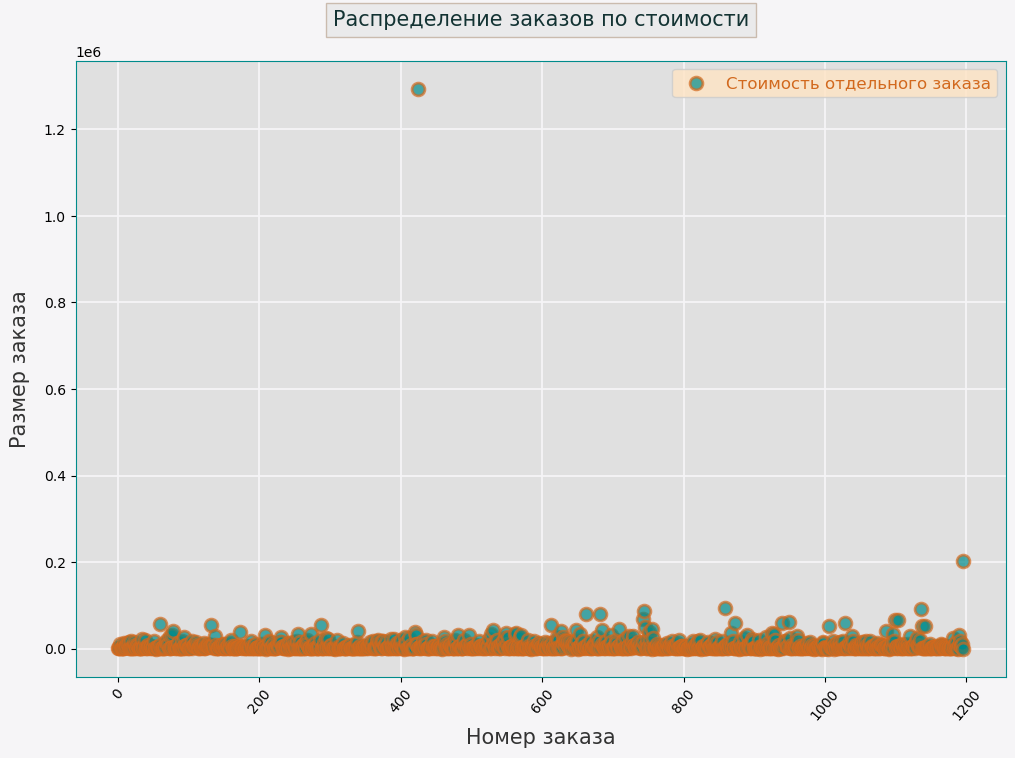

In [40]:
x_values = pd.Series(range(0, len(orders['revenue'])))
y_values = orders['revenue']

plt.figure(figsize=(12, 8)).patch.set_facecolor('#f6f5f7') # Цвет рамки

# Устанавливаем цвет рамки
for side in ['bottom', 'top', 'right', 'left']:
    plt.gca().spines[side].set_color('darkcyan')

plt.gca().set_axisbelow(True) 

plt.scatter(x_values, y_values, alpha=0.7, color='darkcyan', edgecolor='#D2691E', s=85, linewidths=2)


#plt.yticks(ticks=list(range(1, 1400000)))
leg('Распределение заказов по стоимости',
    'Номер заказа', 'Размер заказа', ['Стоимость отдельного заказа'], 11)

_ᅠ ᅠИзменим масштаб по оси y, чтобы увидеть распределение заказов без двух самых дорогих(1.3 млн и 200 к):_ 

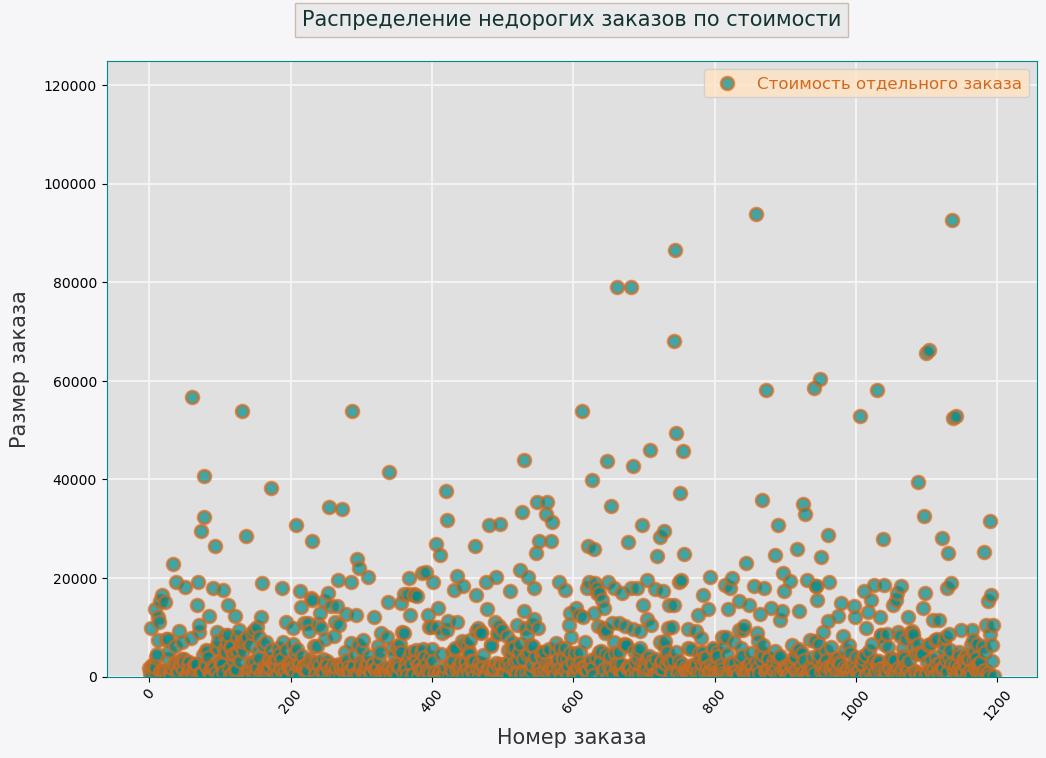

In [41]:
x_values = pd.Series(range(0, len(orders['revenue'])))
y_values = orders['revenue']

plt.figure(figsize=(12, 8)).patch.set_facecolor('#f6f5f7') # Цвет рамки


# Устанавливаем цвет рамки
for side in ['bottom', 'top', 'right', 'left']:
    plt.gca().spines[side].set_color('darkcyan')

plt.gca().set_axisbelow(True) 

plt.scatter(x_values, y_values, alpha=0.7, color='darkcyan', edgecolor='#D2691E', s=85, linewidths=2)

plt.ylim([0, 125000])


#plt.yticks(ticks=list(range(1, 1400000)))
leg('Распределение недорогих заказов по стоимости',
    'Номер заказа', 'Размер заказа', ['Стоимость отдельного заказа'], 11)


 _ᅠ ᅠ Анализ данных по стоимости заказов показал наличие одного крайне существенного выброса, который где-то на порядок превышает сравнительно большие для этого магазина заказы - на сумму почти 1,3 млн. рублей. Кроме него, еще один заказ превышает 200 000 рублей, а следом идут заказы от 100 000 и ниже. Исходя из анализа данного точечного графика, для более точного A/B-теста и исключения влияния выбросов целесообразно выбрать границу аномальных заказов в районе 60 000, оставив довольно равномерное по сумме заказа поле и исключив явные выбросы
._
***

##### Вычисление 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

` Рассчитаем 95-й и 99-й перцентили выручки для определения границы аномальных заказов:`

In [42]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


In [43]:
orders.sort_values(by='revenue', ascending=False)[['transaction_id', 'date', 'revenue']].head(10).style.set_caption('Рейтинг заказов')

,transaction_id,date,revenue
425,590470918,2019-08-19,1294500
1196,3936777065,2019-08-15,202740
858,192721366,2019-08-27,93940
1136,666610489,2019-08-13,92550
744,3668308183,2019-08-27,86620
682,1216533772,2019-08-29,78990
662,1811671147,2019-08-29,78990
743,3603576309,2019-08-09,67990
1103,1348774318,2019-08-12,66350
1099,316924019,2019-08-12,65710


 _ᅠ ᅠ В результате расчетов получили, что не более 5% заказов дороже 28 000 и не более 1% - дороже 58 000. Учитывая изучение точечного графика и рейтинг самых дорогих заказов, можем установить границу цены заказа в 58000, по 99 процентилю, оставив однородную в отношении выбросов массу заказов, удалив при этом совсем немного явно аномальных заказов, в особенности слишком вмешивающийся в расчеты заказ на почти 1.3 млн_

***
__Промежуточный вывод по анализу выбивающихся значений:__
<br><br>
ᅠ ᅠ _`Анализ выбивающихся значений показал, что большая часть пользователей интернет-магазина совершает 1-3 заказа в месяц, что характерно для товаров не первой необходимости. Однако некоторые пользователи делают более 10 заказов за месяц, что может сигнализировать о проблеме удержания клиентов.`<br><br>
ᅠ ᅠ `Граница аномального количества заказов была установлена в 4 заказа в месяц, что соответствует 1% пользователей. Это позволит исключить отдельные случаи, избыточно влияющие на общие метрики.`<br><br>
ᅠ ᅠ `В отношении стоимости заказов было выявлено одно существенное отклонение - заказ на сумму почти 1,3 млн. рублей. Граница аномальных заказов была установлена в 58 000 рублей, что также составляет 1% клиентов, и оставить однородную массу заказов для более точного анализа.`_
***

### Статистический анализ различий между группами на основании "сырых" и "очищенных" данных и сравнение полученных результатов

 >  `В предыдущих разделах мы провели предварительный анализ данных A/B-теста, идентифицировали аномалии и определили границы для их исключения. Теперь нам необходимо провести статистический анализ различий между группами A и B, чтобы определить, являются ли наблюдаемые различия в конверсии и других метриках статистически значимыми.` 
>
>`В этом разделе мы проведем анализ как на "сырых" данных, так и на данных, очищенных от аномальных значений. Это позволит нам оценить влияние выбросов на результаты теста и сравнить полученные выводы.` 
>
>`Результаты этого анализа помогут нам ответить на ключевой вопрос: являются ли изменения, внедренные в группе B, действительно эффективными и приводят ли они к улучшению ключевых показателей бизнеса.`

#### Анализ "сырых" данных

##### Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 


ᅠ ᅠ `Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей. Так как мы работаем с сырыми данными, которые вряд ли распределены нормально и к тому же частично зависимы, то для оценки статистической разницы между группамы применим непараметрический критерий Уилкоксона-Манна-Уитнии, который сравнивает не сами значения, а ранги величин, что делает его устойчивым к выбросам.`<br>
ᅠ ᅠ `Сформулируем гипотезы:`<br>
- __`Нулевая`__ `: различий в среднем количестве заказов между группами нет;` 
- __`Альтернативная:`__ `различия в среднем между группами есть.`

Для начала соберём все начальные данные для статистического анализа в одну таблицу. В неё будут входить следующие столбцы:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

ᅠ ᅠ Накопительные метрики у нас уже есть в таблицах cumulativeDataA(B), а количество заказов, суммарную выручку и количество пользователей в определённую дату высчитать несложно. После чего соединим полученные данные методом merge.

In [44]:
# выручка и количество заказов в день в группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# выручка и количество заказов в день в группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [45]:
# количество посетителей в день в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество посетителей в день в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [46]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(cumulativeData.rename(columns={'orders': 'ordersCummulativeA',   #Достаём наши кумулятивные данные
                                           'revenue': 'revenueCummulativeA', 
                                           'visitors': 'visitorsCummulativeA'})[['date', 
                                                                                 'ordersCummulativeA', 
                                                                                 'revenueCummulativeA' , 
                                                                                 'visitorsCummulativeA']], 
                    left_on='date', right_on='date', how='left')
    
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,visitorsPerDateA,visitorsPerDateB,ordersCummulativeA,revenueCummulativeA,visitorsCummulativeA
0,2019-08-01,24,148579,21,101217,719,713,24,148579,719
1,2019-08-01,24,148579,21,101217,719,713,21,101217,713
2,2019-08-02,20,93822,24,165531,619,581,44,242401,1338
3,2019-08-02,20,93822,24,165531,619,581,45,266748,1294
4,2019-08-03,24,112473,16,114248,507,509,68,354874,1845


_ᅠ ᅠ Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные ordersByUsersA и ordersByUsersB, в которых для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.<br>ᅠ ᅠ Как мы помним из предобработки данных, эти группы пользователей пересекаются - есть 58 пользователей, имеющих заказы как в группе А, так и B, что, как мне кажется, уже уменьшает статистическую значимость между группами просто по причине общей области(Не видел, чтобы в учебном примере было разобрано подобное, оставил как есть)._

In [47]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

_ᅠ ᅠ Подготовим данные к проверке критерием Манна-Уитни: сформируем тестовые образцы sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя,а пользователям без заказов — нули._ 

In [48]:
# Формирование образцов A
sampleA = pd.concat(
    [ordersByUsersA['orders'], pd.Series([0] * (data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])))])

# Формирование образцов B
sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series([0] * (data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])))])


_ᅠ ᅠ Проведём тест Манна-Уитни, используя подготовленные образцы "сырых" данных.Будем использовать стандартный уровень значимости в 5%. Ещё раз посмотрим на гипотезы:_

- `Нулевая` : различий в среднем количестве заказов между группами нет;
- `Альтернативная`: различия в среднем между группами есть.<br><br>
_ᅠ Составим функцию, сравнивающую полученную в результате теста Манна-Уитни p-value с заданным уровнем значимости. Функция принимает аргументы:_<br><br>
    - уровень стат. значимости alpha,
    - тестовый образец А,
    - тестовый образец B;<br><br>
_и возвращает результат сравнения:_

In [49]:
def mannwhit(alpha, sampleA, sampleB):
    alpha = alpha
    print('p-value: {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
    if st.mannwhitneyu(sampleA, sampleB)[1] < alpha:
        print('Отвергаем нулевую гипотезу в пользу первой: Между группами A и B есть статистическая разница в количестве заказов')
    else:
        print('Не можем отвергнуть нулевую гипотезу в пользу первой: Между группами A и B не найдена статистическая разница')

In [50]:
mannwhit(0.05, sampleA, sampleB) # Передаём заранее подготовленные аргументы

p-value: 0.018
Отвергаем нулевую гипотезу в пользу первой: Между группами A и B есть статистическая разница в количестве заказов


_ᅠ ᅠ Также найдём относительное различие в среднем числе заказов между группами B и А:_

In [51]:
print('Относительное различие в среднем числе заказов группы B и A: {0:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))

Относительное различие в среднем числе заказов группы B и A: 13.81%


_ᅠ ᅠ Анализ "сырых" данных A/B-теста показал статистически значимое различие в конверсии между группами A и B. p-value равно 0.018, что ниже выбранного нами уровня стат. значимости в 5% (при выборе alpha=0.01 мы бы, кстати, не смогли отвергнуть нулевую гипотезу), поэтому нулевая гипотеза об отсутствии различий отвергается. Это означает, что изменения, внедренные в группе B, действительно привели к увеличению среднего числа заказов на посетителя по сравнению с группой A. Относительный выигрыш группы B составляет около 13.8%._
***

##### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. 


ᅠ ᅠ `Аналогично найдём статистическую значимость различий между группами в среднем чеке заказа по «сырым» данным, взятым из столбца с выручкой в таблице с заказами. Сформулируем гипотезы:`<br>
- __`Нулевая`__ `: различий в среднем чеке заказа между группами нет;` 
- __`Альтернативная:`__ `различия в среднем чеке между группами есть.`<br><br>
`Уровень статистической значимости также назначим в 5%`

In [52]:
mannwhit(0.05, orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

p-value: 0.729
Не можем отвергнуть нулевую гипотезу в пользу первой: Между группами A и B не найдена статистическая разница


_ᅠ ᅠ Также найдём относительные различия в среднем чеке между группами:_

In [53]:
print('Относительный прирост среднего чека группы B к A: {0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Относительный прирост среднего чека группы B к A: 25.87%


_ᅠ ᅠ Анализ "сырых" данных не выявил статистически значимых различий в среднем чеке между группами A и B. p-value равно 0.73, что значительно выше выбранного уровня значимости в 5%, поэтому нулевая гипотеза об отсутствии различий не отвергается. Однако, несмотря на отсутствие статистической значимости, средний чек группы B заметно выше, чем в группе A - почти на 26%._

***
__Промежуточный вывод по анализу "сырых" данных:__
<br><br>
ᅠ _Методы и ограничения:_

ᅠ ᅠ _`Для анализа сырых данных был использован непараметрический критерий Уилкоксона-Манна-Уитнии, выбранный из-за нестандартного распределения данных A/B-теста и частичной зависимости между значениями. Уровень статистической значимости составил традиционные 5%.`_

ᅠ _Результаты:_

- _ᅠ Конверсия: `Анализ показал статистически значимое увеличение конверсии в группе B (p-value=0.018). Относительный выигрыш группы B составляет 13.8%, что подтверждает эффективность внесенных изменений.`_ 
- _ᅠ Средний чек: `Статистически значимых различий в среднем чеке между группами A и B не обнаружено (p-value=0.73). Однако средний чек в группе B на 26% выше, чем в группе A, что требует дальнейшего анализа и подтверждает предположение о сложном характере распределения величин - даже такая разница в средних не даёт статистического различия выборок.`_ 

ᅠ _Рекомендации:_

- _ᅠ `Дополнить анализ более мощными тестами: Помимо критерия Уилкоксона-Манна-Уитнии, стоит рассмотреть применение других непараметрических тестов, например, теста ранговой корреляции Спирмена.`_ 
- _ᅠ `Провести более детальный анализ среднего чека: Необходимо провести дополнительное исследование, чтобы определить причины значительного различия в среднем чеке между группами, несмотря на отсутствие статистической значимости.`_ 
- _ᅠ `Учесть специфику данных: При интерпретации результатов важно учитывать специфику данных A/B-теста, включая его размер, структуру и характер изменений, внесенных в группу B.`_
***

#### Анализ "очищенных" данных

##### Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

ᅠ ᅠ `Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «очищенным» данным, удалив выбросы на основании аналитически найденных границ. Убираем из рассмотрения пользователей, совершивших 4 и более заказов в месяц, а также пользователей (не сами заказы), совершивших заказы дороже 58000`

In [54]:
orders['revenue']

0         1650
1          730
2          400
3         9759
4         2308
         ...  
1192      6490
1193      3190
1194     10550
1195       100
1196    202740
Name: revenue, Length: 1197, dtype: int64

In [55]:
int(np.percentile(orders['revenue'], 99))

58233

In [56]:
# Пользователи с количеством заказов более трёх.
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id'],
    ],
    axis=0,
)

# Пользователи с заказами дороже 58000 - что составляет 1 персентиль
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], 99))]['visitor_id']

# Не вполне нормальные пользователи, которых мы удалим из последующего анализа. Некоторые ненормальны в квадрате, их удаляем как дубликаты
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
#print(abnormalUsers.head(5))
print('Аномальных пользователей:', abnormalUsers.shape[0])

Аномальных пользователей: 20


_ᅠ ᅠ Всего 20 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Подготовим выборки количества заказов по пользователям по группам теста, но теперь исключив аномальных пользователей:_

In [57]:
# Формирование образцов A
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'], 
                                   pd.Series([0] * (data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])))])

# Формирование образцов B
sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'], 
                                   pd.Series([0] * (data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])))])

_ᅠ ᅠ У нас всё те же гипотезы:_

- `Нулевая` : различий в среднем количестве заказов между группами нет;
- `Альтернативная`: различия в среднем между группами есть.

_ᅠ ᅠ Проведём тест Манна-Уитни, используя подготовленные образцы "очищенных" данных. Будем использовать стандартный уровень значимости в 5%._ 

In [58]:
mannwhit(0.05, sampleAFiltered, sampleBFiltered) # Передаём заранее подготовленные аргументы

p-value: 0.015
Отвергаем нулевую гипотезу в пользу первой: Между группами A и B есть статистическая разница в количестве заказов


_ᅠ ᅠ Также найдём относительное различие в среднем числе заказов между группами B и А по "очищенным" данным:_

In [59]:
print('Относительное различие в среднем числе заказов группы B и A: {0:.2%}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

Относительное различие в среднем числе заказов группы B и A: 15.11%


_ᅠ ᅠ Результат теста конверсии по очищенным данным практически не изменился - различие между выборками всё так же статистически значимо (p-value: 0.015), а относительно неочищенных данных ещё более значимо. Относительный выигрыш группы B увеличился до 15.11%, что говорит о чуть более значительном положительном эффекте изменений при анализе данных, очищенных от аномалий. Теперь с большей уверенностью можем предположить, что изменения, внесенные в группу B, с высокой вероятностью привели к увеличению среднего числа заказов на посетителя._
***

##### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.


ᅠ ᅠ `Аналогично найдём статистическую значимость различий между группами в среднем чеке заказа по «очищенным» данным. Гипотезы те же:`<br>
- __`Нулевая`__ `: различий в среднем чеке заказа между группами нет;` 
- __`Альтернативная:`__ `различия в среднем чеке между группами есть.`<br><br>
`Уровень статистической значимости также назначим в 5%`

In [60]:
mannwhit(0.05, orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormalUsers) ) )]['revenue'], 
               orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers) ) )]['revenue'])

p-value: 0.959
Не можем отвергнуть нулевую гипотезу в пользу первой: Между группами A и B не найдена статистическая разница


_ᅠ ᅠ Также найдём относительные различия в среднем чеке между группами, но без аномальных пользователей:_

In [61]:
print("Относительный прирост среднего чека группы B к A: {0:.2%}".format(
        orders[np.logical_and(orders['group'] == 'B',
               np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()
      / orders[np.logical_and(orders['group'] == 'A',
               np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)
      )

Относительный прирост среднего чека группы B к A: -1.39%


_ᅠ ᅠ Анализ "очищенных" данных также не выявил статистически значимых различий в среднем чеке между группами A и B. После удаления аномалий p-value даже немного увеличился - до 0.58, что ещё выше выбранного уровня значимости в 5%. Гипотезу об отсутствии различий мы отвергнуть всё так же не можем._<br>
_ᅠ ᅠ Средний чек группы B при анализе "грязных" данных был заметно выше, чем в группе A, но теперь преимущество сменилось отставанием в 1.4%. Видим яркую демонстрацию влияния выбросов. Очень вероятно, что так сказывается влияние конкретного заказа на 1.3 млн 19 числа в группе B, на который средний чек реагирует очень ощутимо, а параметр Манна-Уитни - нет._

_ᅠ ᅠ Напомним, как выглядели графики относительного различия для среднего чека и изменения кумулятивного среднего количества заказов на посетителя от группы B к группе A:_

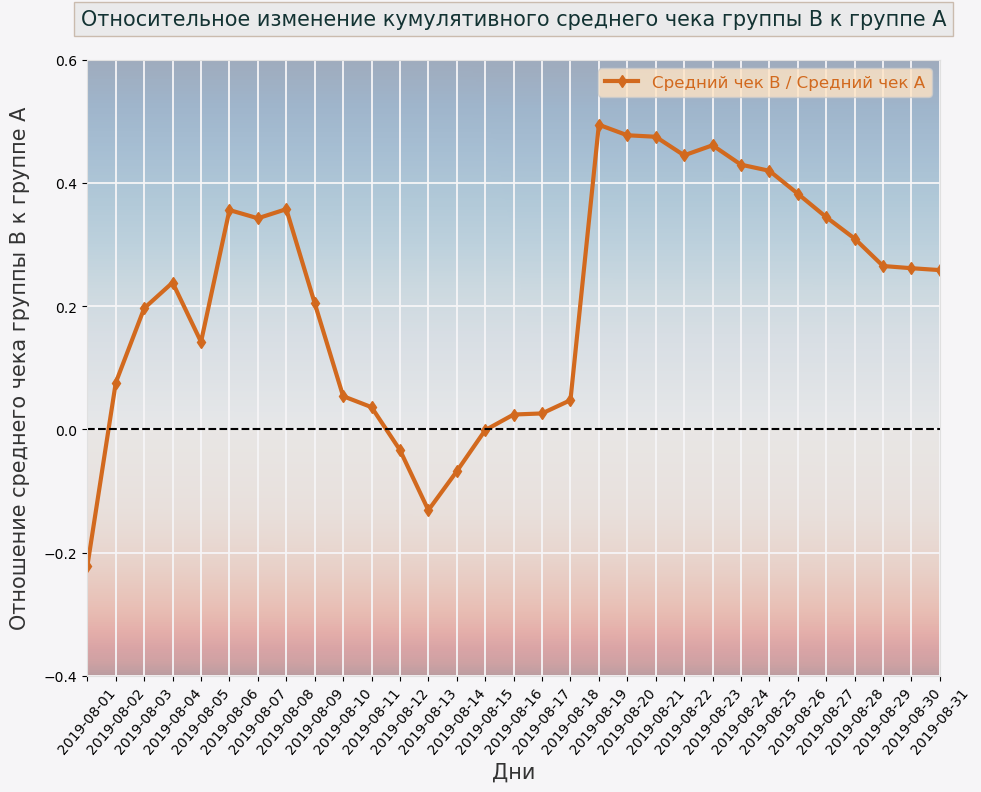

In [62]:
grad(0.6, 0, -0.4)


# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
         mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, marker='d', markersize=6, linewidth=3)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

leg('Относительное изменение кумулятивного среднего чека группы B к группе A',
     'Дни', 'Отношение среднего чека группы B к группе A', ['Средний чек B / Средний чек А'], 11)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[11:20])

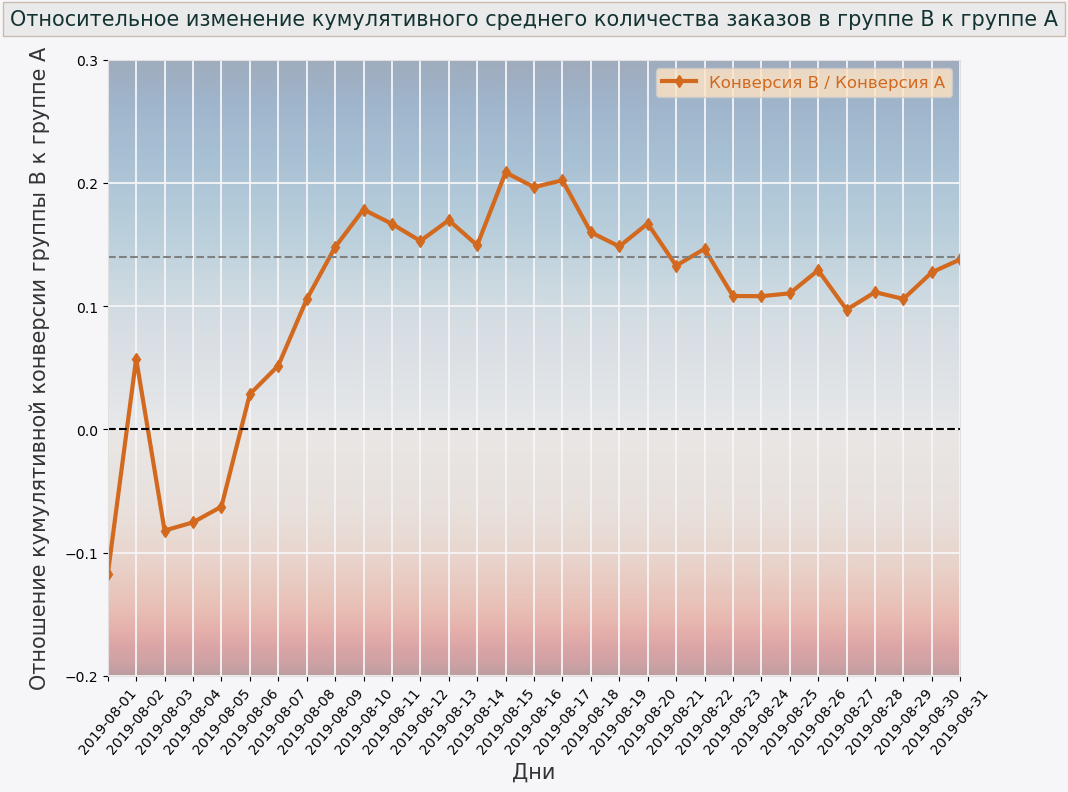

In [63]:
grad(0.3, 0, -0.2)

# Cтроим отношение конверсий
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост кумулятивного среднего количества заказов ",
         marker='d', markersize=6, linewidth=3)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')


leg('Относительное изменение кумулятивного среднего количества заказов в группе B к группе A',
     'Дни', 'Отношение кумулятивной конверсии группы B к группе A', ['Конверсия B / Конверсия А'], 11)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[11:20])




_ᅠ ᅠ Теперь проверим те же графики для очищенных данных, исключив аномальных пользователей. С их посещениями что-либо сделать не представляется возможным, поэтому оставляем как есть. Выбросов количественно немного, на посещениях не должно серьёзно сказаться. Строим график относительного изменения среднего чека в группе B к группе A по очищенным данным:_

In [64]:
ords = orders[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]

# Для перезапуска нужно чистить переменные

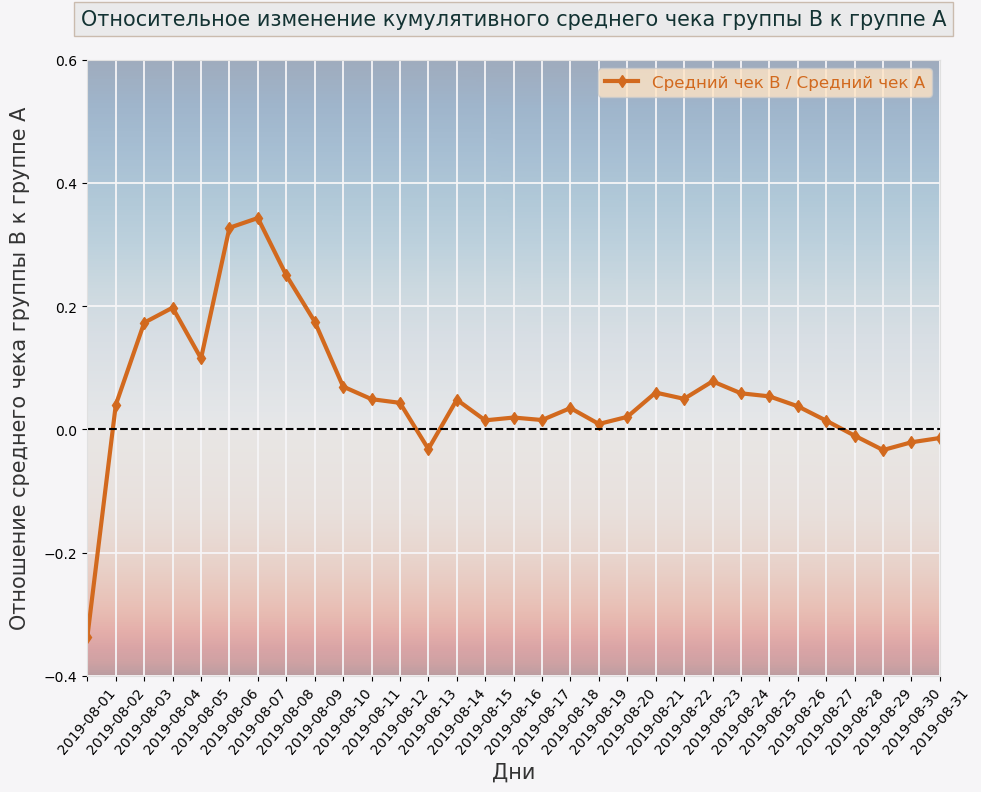

In [65]:
grad(0.6, 0, -0.4)


datesGroups = ords[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: ords[
        np.logical_and(
            ords['date'] <= x['date'], ords['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]


# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
         mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, marker='d', markersize=6, linewidth=3)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

leg('Относительное изменение кумулятивного среднего чека группы B к группе A',
     'Дни', 'Отношение среднего чека группы B к группе A', ['Средний чек B / Средний чек А'], 11)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[11:20])

_ᅠ ᅠ Построим также график изменения кумулятивного среднего количества заказов в группе B по отношению к изменению в группе B по очищенным данным:_

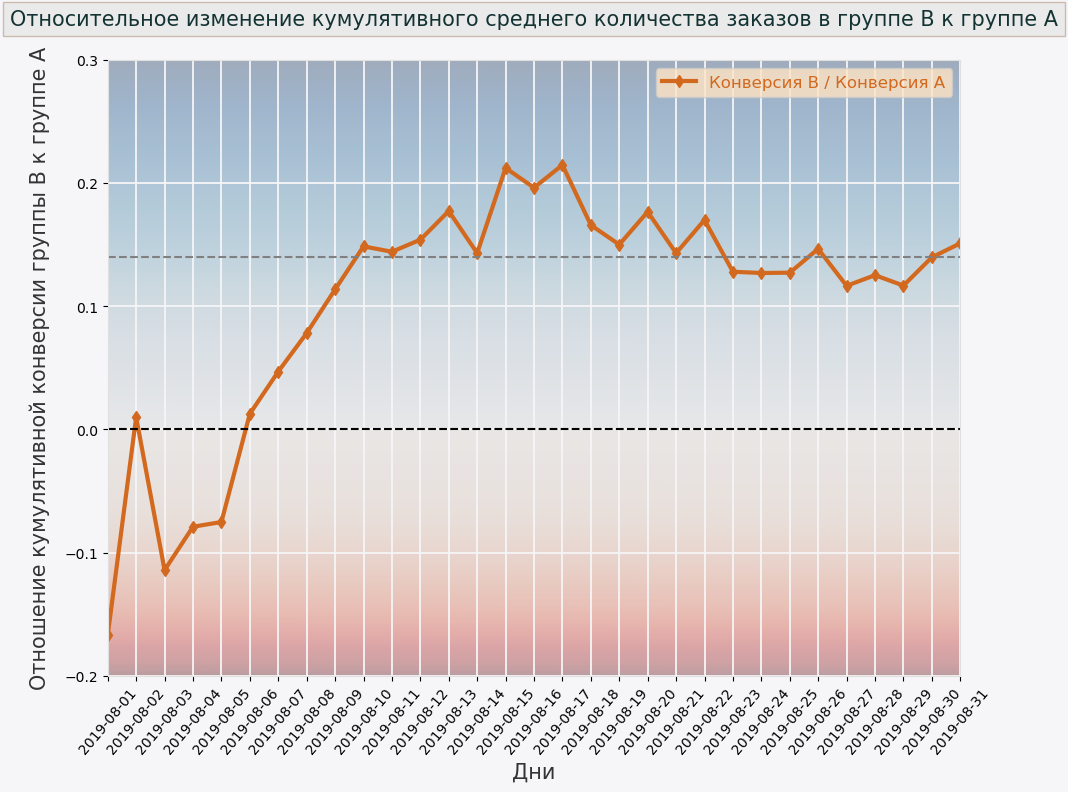

In [66]:
grad(0.3, 0, -0.2)


mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост кумулятивного среднего количества заказов ",
         marker='d', markersize=6, linewidth=3)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')


leg('Относительное изменение кумулятивного среднего количества заказов в группе B к группе A',
     'Дни', 'Отношение кумулятивной конверсии группы B к группе A', ['Конверсия B / Конверсия А'], 11)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors[5:20])

_ᅠ ᅠ График различия среднего чека говорит о том, что результаты группы B уравновесились во всех смыслах - изменения стабилизировались во времени и кумулятивный средний чек в группе B стал даже ниже такового в группе А. Причём до удаления аномалий он показывал значительное преимущество, в основном благодаря резкому скачку в районе 20 числа. 
График прироста конверсии группы B к группе А, наоборот, показал улучшение в  пользу группы B, но довольно незначительное. По графику относительной конверсии уже нельзя наверняка сказать, что тест шёл достаточное количество времени - флуктуации ещё есть даже после удаления аномалий. В целом по этому графику можно оценить изменения в группе B как хорошо влияющие на увеличение конверсии( +15%)._

***
__Промежуточный вывод по анализу "очищенных" данных:__
<br><br>
ᅠ ᅠ _`Посчитали статистическую значимость различий в среднем числе заказов на пользователя между группами по «очищенным» данным, избавившись от выбросов на основании аналитически найденных границ. Убрали из рассмотрения пользователей, совершивших 4 и более заказов в месяц, а также заказы дороже 58000. Всего нашли 20 аномальных пользователей, удалили их и посчитали статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным, проведя тест Манна-Уитни. Использовали стандартный уровень значимости в 5%.`_<br>
ᅠ ᅠ _`Анализ "очищенных" данных предоставил более точную картину результатов A/B-теста, чем анализ "сырых" данных. Однако необходимо провести дальнейшие исследования, чтобы окончательно оценить эффективность изменений и выявить причины отсутствия значимых различий в среднем чеке.`_

ᅠ _Результаты влияния "очистки" данных:_

- _ᅠ Конверсия: `Удаление аномальных пользователей подтвердило статистическую значимость различия в конверсии между группами A и B (p-value=0.015 уменьшилось с 0.018 ). Относительный выигрыш по количеству заказов группы B увеличился до 15.1% (с 13.81%), что говорит о чуть более значительном положительном эффекте изменений после исключения выбросов. Внесенные изменения в группу B с высокой вероятностью привели к увеличению среднего числа заказов на посетителя. "Очистка" данных укрепила уверенность в результатах теста.`_ 
- _ᅠ Средний чек: `Анализ "очищенных" данных по-прежнему не выявил статистически значимых различий в среднем чеке (p-value=0.959 увеличилось с 0.73). Однако, средний чек в группе B уменьшился до -1.4% (с целых +26%) по сравнению с группой A, что подтверждает существенное влияние аномальных данных на этот показатель. "Очистка" данных продемонстрировала значительное влияние выбросов на результаты анализа этого показателя, что требует дальнейшего исследования.`_ 

ᅠ _Рекомендации:_

- _ᅠ `Дополнительный анализ среднего чека: Необходимо провести более глубокий анализ среднего чека, включая исследование влияния конкретных заказов (например, заказа на 1.3 млн в группе B), чтобы понять реальные причины отсутствия статистически значимых различий.`_ 
- _ᅠ `Изучение влияния аномальных пользователей: Важно проанализировать поведение аномальных пользователей, чтобы понять, какие факторы привели к их нестандартному поведению и как это влияет на общие результаты A/B-теста.`_ 
- _ᅠ `Разработка альтернативных метрик: Помимо среднего чека, стоит рассмотреть использование других, менее чувствительных к выбросам метрик для оценки влияния изменений на доходы, например, медианный чек или суммарный доход от заказов.`_
***

### _Принятие решения по результатам теста. Варианты решений:_<br>
_`1.`_ __Остановить тест, зафиксировать победу одной из групп.__<br>
<br>
_`2.`_ __Остановить тест, зафиксировать отсутствие различий между группами.__<br>
<br>
_`3.`_ __Продолжить тест.__

ᅠ ᅠ _На да данном этапе проведения теста мы имеем установившуюся картину по среднему чеку, если опираться на анализ "чистых" данных, а это на мой взгляд самая важная метрика для бизнеса. Можно утверждать, что по среднему чеку у группы B нет преимуществ, особенно с учетом установившегося характера изменений. Конверсия - важный показатель, но если она не приводит к увеличению прибыли, то в данном случае она может оказаться метрикой "тщеславия". Покупатели могут, например, начать дробить заказы с целью получаения каких-либо акций или скидок, что будет увеличивать количество заказов на покупателя, но к выручке отношения иметь не будет. Но в нашем случае она увеличилась, приводя к довольно малому уменьшению среднего чека на очищенных данных, а следовательно имеем статистически значимое улучшение ключевой метрики +15%. Есть легкая неуверенность в достаточной продолжительности теста, но в целом отрицать позитивные изменения здесь сложно._<br>
ᅠ ᅠ _Исходя из вышесказанного, считаю правильным остановить тест на данном этапе и признать преимущества группы B в конверсии, которая хоть и не до конца установилась, но не показывает больших скачков, существенными для признания её победы в тесте._
***

## Вывод

>_В ходе проекта была проведена приоритизация гипотез, анализ A/B-теста и принятие решения о его продолжении/остановке._
***
__1.__ __Приоритизация гипотез:__

 •    Методы ICE и RICE дали разные результаты приоритезации по причине высокой степени влияния показателя охвата.<br><br> 
 •    Гипотеза о скидке на день рождения, имеющая высокую уверенность и низкие затраты, получила низкий приоритет по методике RICE.<br><br>
 •    Добавление формы подписки на все основные страницы заняло первое место по фреймворку RICE, благодаря высокому охвату (Reach), перейдя с третьего места по ICE.<br><br> 
 •    Дополнительный анализ гипотез, с учетом специфики бизнеса и целей тестирования, позволил выявить наиболее перспективные направления для A/B-тестирования, а так же разработать некоторые рекомендации по различным вариантам кастомизации перспективных с точки зрения приоритезации гипотез.<br> <br>
***
__2.__ __Анализ A/B-теста:__

ᅠ ᅠ Проведен анализ кумулятивных метрик "грязных" данных A/B-теста, выявлены выбивающиеся значения и определены пороговые значения для последующей "очистки".<br><br> 
ᅠ ᅠ Анализ показал, что большинство пользователей интернет-магазина совершают 1-3 заказа в месяц, что характерно для товаров не первой необходимости.<br><br> 
ᅠ ᅠ Применение метода Манна-Уитни для анализа "очищенных" данных показало более точные результаты, чем анализ "сырых" данных.<br><br>

___`Результаты "очистки" данных:`___<br>  

- _ᅠ Конверсия:_   Удаление аномальных пользователей подтвердило статистическую значимость различия в конверсии между группами A и B. Относительный выигрыш по количеству заказов группы B увеличился до 15%, что говорит о чуть более значительном положительном эффекте изменений после исключения выбросов. Внесенные изменения в группу B с высокой вероятностью привели к увеличению среднего числа заказов на посетителя. "Очистка" данных укрепила уверенность в результатах теста.<br> <br>
- _ᅠ Средний чек:_ Анализ "очищенных" данных по-прежнему не выявил статистически значимых различий в среднем чеке. Однако, средний чек в группе B стал даже ниже, чем в группе A, хотя на "грязных" данных у группы B по этому параметру было преимущество в 25% на момент проведения теста, что подтверждает существенное влияние аномальных данных на этот показатель. "Очистка" данных продемонстрировала значительное влияние выбросов на результаты анализа этого показателя, что требует дальнейшего исследования.<br>  
***
  
  
> __Решение по результатам теста:__<br> 
>
>• Анализ "чистых" данных демонстрирует отсутствие преимуществ у группы B по среднему чеку.<br>  
>• Рекомендуется провести более глубокий анализ среднего чека и поведения аномальных пользователей, чтобы получить более полное понимание результатов A/B-теста и направления проведения будущих статистических анализов.<br><br>
>• Предлагается A/B-тест, признав изменения, внесенные в группу B, позитивно влияющими на конверсию и заслуживающими внедрения в приложение<br>

